# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE
### ---- 1 Define the problem ----

Problem Statement: Create a Model that helps in predicting the salaries of a job postiong based on different parameters provided like Job description,

In [1]:
#customizing the Notebook screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
# display(HTML("<style>.prompt { display:none !important; }</style>"))

In [2]:
#Importing supporting Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib 

## Part 2 - DISCOVER -

### ---2. Load and 3. Clean the Data done in the data object creation---
 Read the data  by creating a data object from the Load Model Data class which inlcude the cleaning procedures and the 

# Definition of Data class
    Initialize the data object by passing in the following inputs:
        train_feature_file  -input csv that have all features for training the model
        train_target_file -data of the target class
        test_file - test data csv file
        cat_cols - categorical columns present in the data
        num_cols - Numerical columns present in the data
        target_col - target column as in the target variable
        id_col - unique identifier of the row.
        
    _ before the function name indicates the private function
    @static method before a function definition means that the function can be called with out class object being initialized.
    __init__ initializes all the parameters used in the class.

In [3]:
class LoadModelData:
    
    def __init__(self, train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col):
        '''create train and test dataframe'''
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.feature_cols = cat_cols + num_cols
        self.target_col = target_col
        self.id_col = id_col
        
        #Initialize the variables in the class.
        self.label_encoders = {}
        self.train_df = self._create_train_df(train_feature_file, train_target_file) #Preprocess is True by default and encodes the labels.
        self.test_df = self._create_test_df(test_file)
    
    def label_encode_data(self, df, cols):
        '''creates one label encoder for each column in the data object instance'''
        for col in cols:
            if col in self.label_encoders:
                #if label encoder already exits for col, use it
                self._label_encoder_col(df, col, self.label_encoders[col])
            else:
                self._label_encoder_col(df, col)
    
    def inverse_encode_data(self, df, cols):
        '''does inverse label encoding'''
        for col in cols:
            if col in self.label_encoders:
                self._inverse_label_encoder_col(df, col)  
            else:
                raise ValueError("Label Encoder not defined")

    def _label_encoder_col(self, df, col, le=None):
        '''label encodes data'''
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le
        
    def _inverse_label_encoder_col(self, df, col):
        '''inverse label encodes data'''
        le = self.label_encoders[col]
        df[col] = le.inverse_transform(df[col])
        
    #create the train df with the label encoding
    def _create_train_df(self, train_feature_df, train_target_df, preprocess=True, label_encode=True):
        '''loads and merges training data features and targets, preprocesses data, encodes data'''
        train_feature_df = self._load_data(train_feature_file)
        train_target_df = self._load_data(train_target_file)
        train_df = self._merge_dfs(train_feature_df, train_target_df)
        if preprocess:
            train_df = self._clean_data(train_df)
            train_df = self._shuffle_data(train_df)
        if label_encode:
            self.label_encode_data(train_df, self.cat_cols)
        return train_df
    
    #create the test df with the label encoding
    def _create_test_df(self, test_file, label_encode=True):
        '''loads and label encodes test data'''
        test_df = self._load_data(test_file)
        if label_encode:
            self.label_encode_data(test_df, self.cat_cols)
        return test_df
    
    #to load the data from csv    
    def _load_data(self, file):
        return pd.read_csv(file)
    
    #merge two dataframes provided as input, some parameters are initialized with the default values,others need to be passed explicitly
    def _merge_dfs(self, df1, df2, key=None, left_index=False, right_index=False):
        return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    
    # Clean the target variable for null values
    def _clean_data(self, df):
        '''remove rows that contain salary <= 0 or duplicate job IDs'''
        df = df.drop_duplicates(subset='jobId')
        df = df[df.salary>0]
        return df
    
    # Shuffles data and resets the index of the input dataframe
    def _shuffle_data(self, df):
         return shuffle(df).reset_index()

### ---- 4 Explore the data (EDA) ----

# Definition of Feature Generator class
Initialize the Feature generator object by passing in the following inputs:
        data -  data object created
        
    _ before the function name indicates the private function
    @static method before a function definition means that the function can be called with out class object being initialized.
    __init__ initializes all the parameters used in the class.

In [4]:
class StatisticalFeatureGenerator:
    def __init__(self, data):
        '''initializes class and creates groupby object for data'''
        self.data = data
        #able to generate features for new companies, but less accurate
        #self.cat_cols = ['jobType', 'degree', 'major', 'industry']
        self.cat_cols = data.cat_cols
        self.groups = data.train_df.groupby(self.cat_cols)
        
    def add_grouped_statistics(self):
        '''adds groupis tics  statistics to data stored in data object'''
        #get group stats
        group_stats_df = self._calculate_group_stats()
        group_stats_df.reset_index(inplace=True)
  
        #merge derived columns to original df
        self.data.train_df = self._merge_new_cols(self.data.train_df, group_stats_df, self.cat_cols, fillna=True)
        self.data.test_df = self._merge_new_cols(self.data.test_df, group_stats_df, self.cat_cols, fillna=True)      
        
        #update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_column_lists(self.data, cat_cols=group_stats_cols)  
        
    def _calculate_group_stats(self):
        '''calculates group statistics'''
        target_col = self.data.target_col
        group_stats_df = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        group_stats_df['group_max'] = self.groups[target_col].max()
        group_stats_df['group_min'] = self.groups[target_col].min()
        group_stats_df['group_std'] = self.groups[target_col].std()
        group_stats_df['group_median'] = self.groups[target_col].median()
        return group_stats_df
        
    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        '''merges engineered features with original df'''
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def _extend_column_lists(self, data, cat_cols=[], num_cols=[]):
        '''addes engineered feature cols to data col lists'''
        data.num_cols.extend(num_cols)
        data.cat_cols.extend(cat_cols)
        data.feature_cols.extend(num_cols + cat_cols)

### ---- 5 Establish a baseline ----
We choose the best performing model as the one that have the lease Mean Square Error(MSE), For this we generate different models ,cross validate the results to calculate the mertics and compare the results and chose the one that matches our expectations.


# Definition of Model Container class

In [5]:
class GenerateModels:
    def __init__(self, models=[]):
        '''initializes model list and dicts as empty. We can later add models using the add model function'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        
    def add_model_to_evaluate(self, model):
        self.models.append(model)

    def cross_validate_model(self, data, k=3, num_procs=1):
        '''cross validate models using given data'''
        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
    
    def select_best_performing_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def fit_best_model(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def predict_from_best_model(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        try:
            with open('Model.txt', 'w') as file:
                file.write(str(self.best_model))
            models.get_feature_importance(models.best_model, data.feature_cols).to_csv('Feature_Importance_Calculations.csv') 
            np.savetxt('prediction_from_test_set.csv', self.predictions, delimiter=',')
            return 'Files Saved'
        except Exception as e:
            return "Error Saving Results"+str(e)
        
    def save_model(self):
        try:
            joblib.dump(self.best_model, 'Best_Model.pkl') 
            return "Model Saved"
        except Exception as e:
            return "Error saving Model:"+str(e)
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))

        feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
        feature_importances.plot.bar()
        plt.show()

Initializing the parameters to load the data using the data object created in the next step

In [6]:
#define number of processors to use for parallel runs
num_procs = 4
#set verbose level for models
verbose_lvl = 0
#define input file paths
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_file = 'data/test_features.csv'
#define variables that are needed for initializing the data object
cat_cols = ['jobType', 'degree', 'major', 'industry'] # 'companyId' -May affect predictions when we add new companies
num_cols = ['yearsExperience', 'milesFromMetropolis']
#target variables
target_col = 'salary'
#unique row identifier
id_col = 'jobId'
#turn feature engineering on/off - to initialize the feature generator class.
engineer_features = True

### Create Data object

At this step, data is preprocessed, categorical labels were encoded and ready for analysis

In [7]:
data = LoadModelData(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

Generate the statistical features measure values for the target column

In [8]:
if engineer_features:
    feature_generator = StatisticalFeatureGenerator(data)
    feature_generator.add_grouped_statistics()

In [9]:
# print(data.test_df)

# Create model container object  and add models to it

In [10]:
#create model container
models = GenerateModels()

#create models -- hyperparameter tuning already done by hand for each model
models.add_model_to_evaluate(LinearRegression())
models.add_model_to_evaluate(RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, \
                                       max_features=8, verbose=verbose_lvl))
models.add_model_to_evaluate(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))

# Cross validate models, then select, fit, and score test data with best model

In [11]:
models.cross_validate_model(data, k=2, num_procs=num_procs)

In [12]:
models.select_best_performing_model()

In [13]:
models.fit_best_model(data.train_df[data.feature_cols], data.train_df[data.target_col])

In [14]:
models.predict_from_best_model(data.test_df[data.feature_cols])

# Results

In [15]:
models.save_model()

'Model Saved'

In [16]:
models.save_results()

'Files Saved'

In [17]:
print(joblib.load('Best_Model.pkl'))

GradientBoostingRegressor(max_depth=7, n_estimators=40)



Model Summaries:


 LinearRegression() - MSE: 370.9590587345574

 RandomForestRegressor(max_depth=15, max_features=8, min_samples_split=80,
                      n_estimators=60, n_jobs=4) - MSE: 359.0367602471418

 GradientBoostingRegressor(max_depth=7, n_estimators=40) - MSE: 355.3109428431121

Best Model:
 GradientBoostingRegressor(max_depth=7, n_estimators=40)

MSE of Best Model
 355.3109428431121

Feature Importances
                      importance
feature                        
group_mean             0.654970
yearsExperience        0.185714
milesFromMetropolis    0.128653
group_median           0.023768
group_min              0.005461
group_std              0.001245
group_max              0.000158
jobType                0.000013
major                  0.000009
degree                 0.000005
industry               0.000004


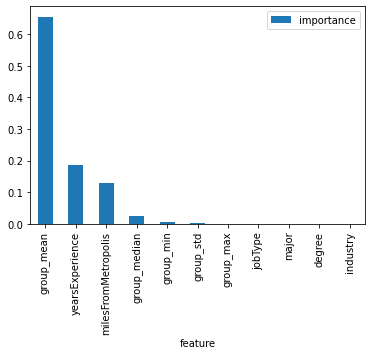

In [18]:
models.print_summary()